In [249]:
import pandas as pd

data = pd.read_csv('train_area_features.csv')

In [250]:
data = data.dropna()  # Drop rows with missing values

In [251]:
from sklearn.model_selection import train_test_split

# Define the target and features
target = data['Bags']
features = data.drop(['Bags'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [252]:
test_ids = X_test['ID']  # Keep track of IDs
X_train = X_train.drop(['ID'], axis=1)  
X_test = X_test.drop(['ID'], axis=1)

In [253]:
from sklearn.preprocessing import StandardScaler
import joblib

scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, 'models/scaler.pkl')

['models/scaler.pkl']

In [254]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [255]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.32832589852849847
R-squared: 0.13005945630054405


In [256]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
mse = []
r2 = []
tree_num = []
for trees in range(1, 500, 10):
    tree_num.append(trees)
    rf_model = RandomForestRegressor(n_estimators=trees, random_state=42)
    # rf_model.fit(X_train_scaled, y_train)
    # y_pred_rf = rf_model.predict(X_test_scaled)

    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)


    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    mse.append(mse_rf)
    r2.append(r2_rf)
    # print(f'Random Forest Mean Squared Error: {mse_rf}')
    # print(f'Random Forest R-squared: {r2_rf}')
df = pd.DataFrame({'trees': tree_num, 
                   'mse': mse, 
                   'r2': r2
                })


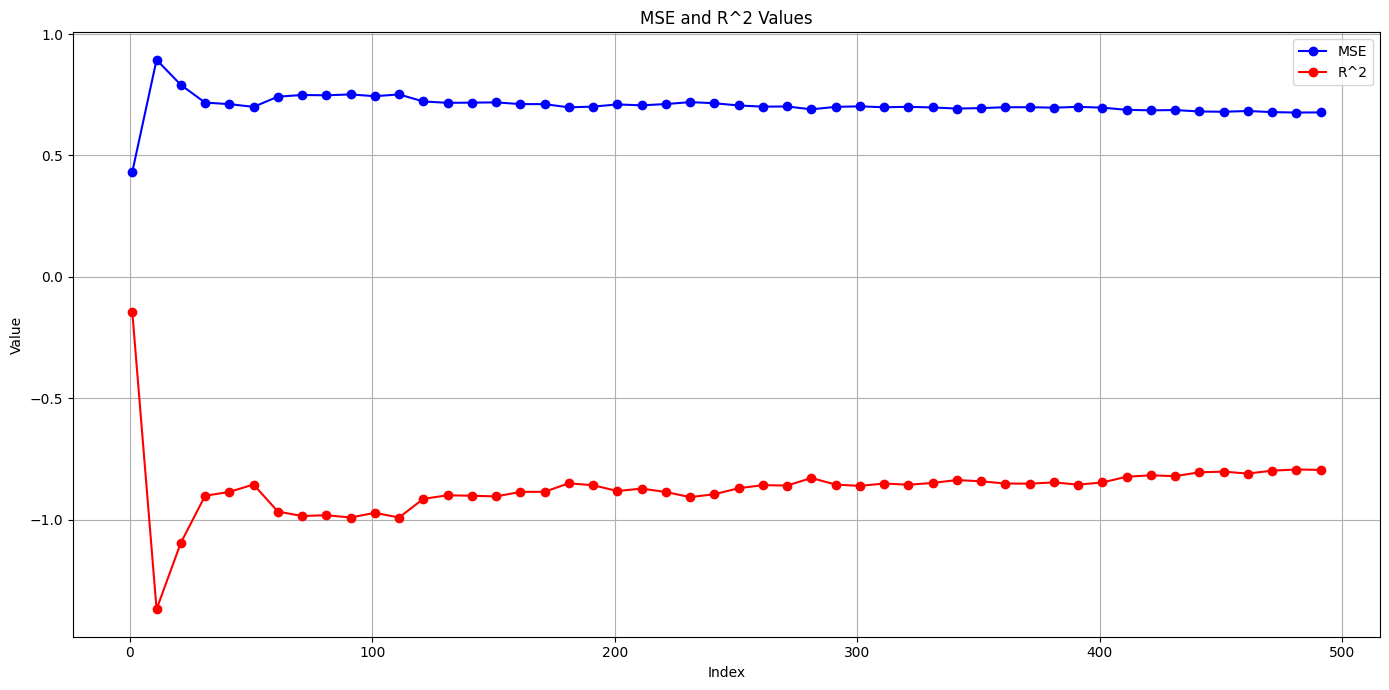

In [257]:
# Plotting
plt.figure(figsize=(14, 7))

# Plot MSE
plt.plot(df['trees'], df['mse'], marker='o', color='blue', label='MSE')

# Plot R^2
plt.plot(df['trees'], df['r2'], marker='o', color='red', label='R^2')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('MSE and R^2 Values')
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

In [258]:
rf_model = RandomForestRegressor(n_estimators=150, random_state=42)
# rf_model.fit(X_train_scaled, y_train)
# y_pred_rf = rf_model.predict(X_test_scaled)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

In [259]:
import numpy as np

# Calculate errors
errors = np.abs(y_test - y_pred_rf)
# Create a DataFrame with IDs and errors (assuming you have an 'ID' column for your test data)
test_df = pd.DataFrame({
    'ID': test_ids,  # IDs for test set
    'Actual': y_test,
    'Predicted': y_pred_rf,
    'Error': errors
})

# Sort by error and select the top N images with the greatest errors
top_n = 20  # Number of images with the greatest errors to display
top_errors_df = test_df.nlargest(top_n, 'Error')


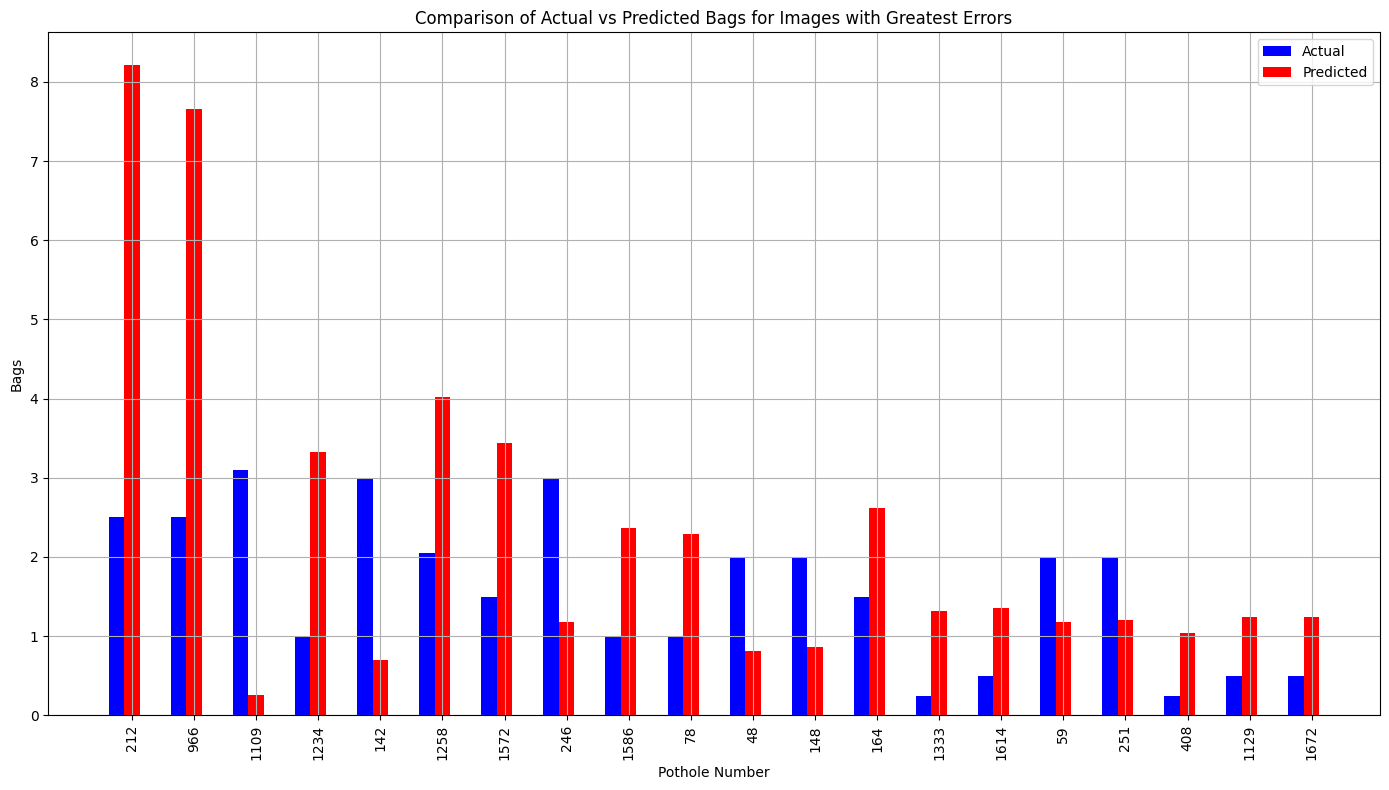

In [260]:
import matplotlib.pyplot as plt
# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

bar_width = 0.25
index = np.arange(top_n)

# Plot actual vs predicted values for the top N images with the greatest errors
bar1 = ax.bar(index - bar_width, top_errors_df['Actual'], bar_width, label='Actual', color='b')
bar2 = ax.bar(index, top_errors_df['Predicted'], bar_width, label='Predicted', color='r')

# Add labels and title
ax.set_xlabel('Pothole Number')
ax.set_ylabel('Bags')
ax.set_title('Comparison of Actual vs Predicted Bags for Images with Greatest Errors')
ax.set_xticks(index)
ax.set_xticklabels(top_errors_df['ID'], rotation=90)
ax.legend()
ax.grid(True)

# Show plot
plt.tight_layout()
plt.show()

In [261]:
joblib.dump(model, 'models/lin_reg_model.pkl')
joblib.dump(rf_model, 'models/random_forest_model.pkl')

['models/random_forest_model.pkl']

In [262]:
# Load the model and scaler
model = joblib.load('models/random_forest_model.pkl')
scaler = joblib.load('models/scaler.pkl')  

new_data = pd.read_csv('test_area_features.csv')
# Features used during training
training_features = ['Area', 'BoundingBoxArea', 'Width', 'Height', 'Ratio']

# Add missing features with default values
for feature in training_features:
    if feature not in new_data.columns:
        new_data[feature] = 0  # or an appropriate default value

# Ensure columns are in the same order as during training
new_data = new_data[training_features]

# Scale the new data
# new_data_scaled = scaler.transform(new_data)
# Make predictions
predictions = model.predict(new_data)


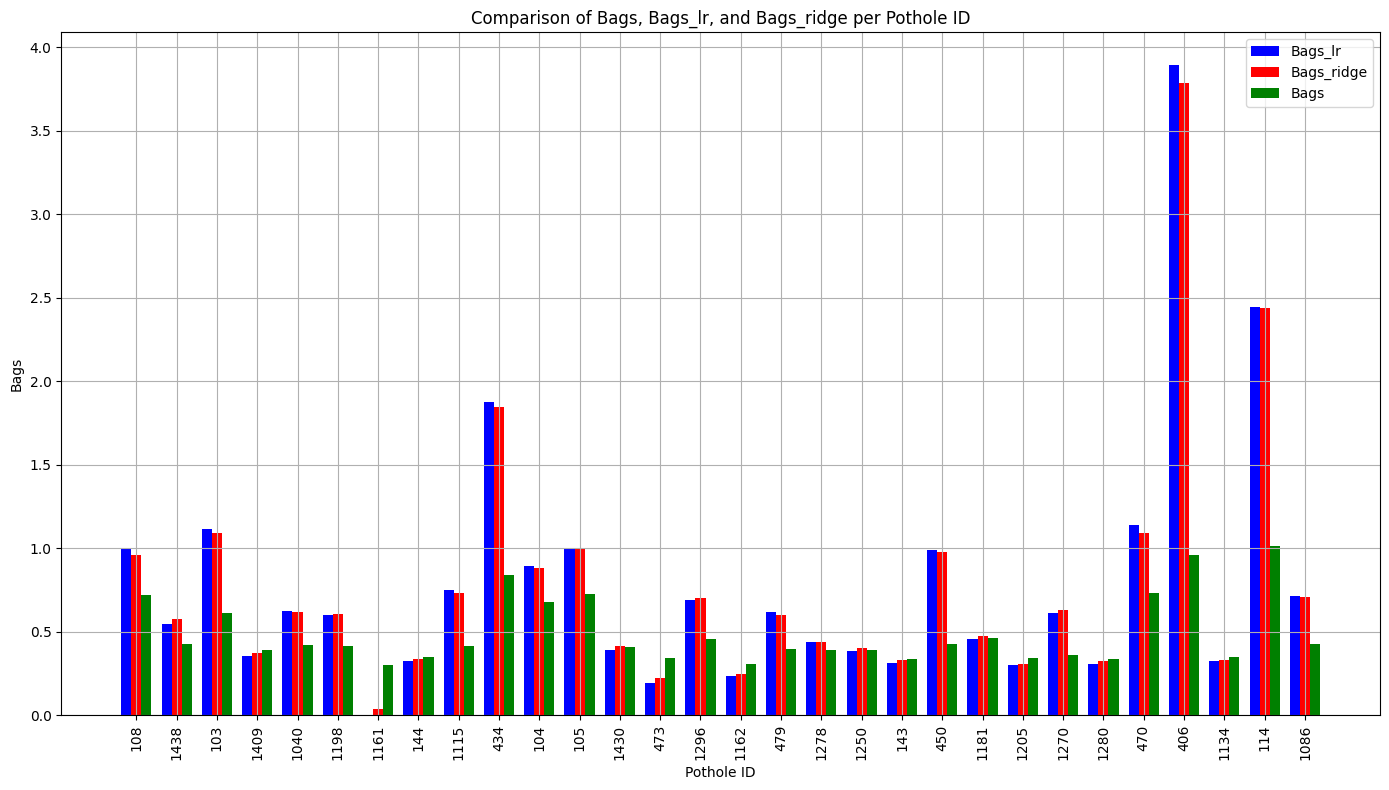

In [263]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the original DataFrame
original_df = pd.read_csv('test_area_features.csv')

# Create a new DataFrame with the specified columns
df = original_df[['ID', 'Bags_lr', 'Bags_ridge', 'Bags']].copy()

# Assuming predictions is a list or array of predictions
df['Bags'] = predictions

# Prepare data for plotting
ids = df['ID']
bags_lr = df['Bags_lr']
bags_ridge = df['Bags_ridge']
bags = df['Bags']

bar_width = 0.25  # Width of each bar
index = np.arange(len(ids))  # The x locations for the groups

# Create a bar plot
plt.figure(figsize=(14, 8))

# Plot Bars
plt.bar(index - bar_width, bags_lr, bar_width, label='Bags_lr', color='b')
plt.bar(index, bags_ridge, bar_width, label='Bags_ridge', color='r')
plt.bar(index + bar_width, bags, bar_width, label='Bags', color='g')

# Add labels and title
plt.xlabel('Pothole ID')
plt.ylabel('Bags')
plt.title('Comparison of Bags, Bags_lr, and Bags_ridge per Pothole ID')
plt.xticks(index, ids, rotation=90)  # Rotate x labels for better visibility
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


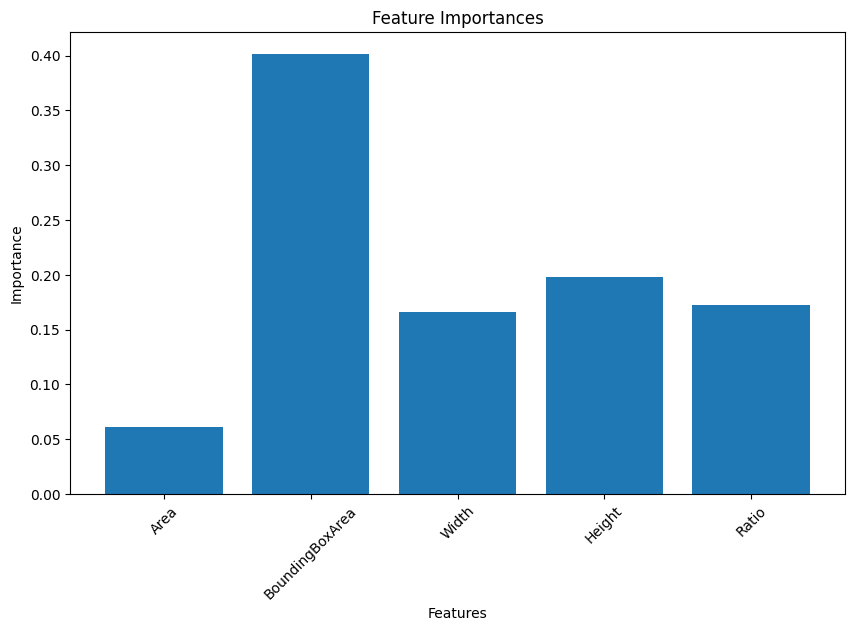

In [264]:
import matplotlib.pyplot as plt

feature_importances = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(training_features, feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=45)
plt.show()
